# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the [README.md] to setup, train and deploy your model. This notebook will show
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

## 5. Data Science
You will need Tensorflow installed to run this section.

In [72]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


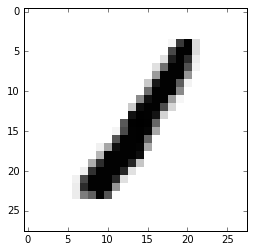

In [73]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

In [74]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

x = tf.placeholder(tf.float32, [None,784], name="x")
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0.9197


# Dockerize and Train Model

In [25]:
!argo submit ../workflows/training-tf-mnist-workflow.yaml

Name:             kubeflow-train-2x2pq
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Fri Feb 09 15:37:30 +0000 (1 second ago)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio
  tfjob-version-hack: 1


In [26]:
!argo list

NAME                   STATUS    AGE    DURATION
kubeflow-train-2x2pq   Running   15s    15s 


In [30]:
!argo get kubeflow-train-2x2pq

Name:             kubeflow-train-2x2pq
Namespace:        default
ServiceAccount:   default
Status:           Succeeded
Created:          Fri Feb 09 15:37:30 +0000 (3 minutes ago)
Started:          Fri Feb 09 15:37:30 +0000 (3 minutes ago)
Finished:         Fri Feb 09 15:40:54 +0000 (23 seconds ago)
Duration:         3 minutes 24 seconds
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio
  tfjob-version-hack: 1

STEP                     PODNAME                          DURATION  MESSAGE
 ✔ kubeflow-train-2x2pq                                             
 ├---✔ build-push        kubeflow-train-2x2pq-4048894882  1m        
 └---✔ train             kubeflow-train-2x2pq-1479042668  1m        


Delete argo job to free persistent disk usage.

In [ ]:
!argo delete --all

# Dockerize and Deploy Runtime Model

In [32]:
!argo submit ../workflows/serving-tf-mnist-workflow.yaml

Name:             seldon-package-db5m7
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Fri Feb 09 15:42:12 +0000 (now)
Parameters:       
  version:        0.1


In [34]:
!argo list

NAME                   STATUS      AGE   DURATION
seldon-package-db5m7   Running     1m    1m 
kubeflow-train-2x2pq   Succeeded   5m    3m 


## Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n default -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:80
```

In [150]:
import requests
from requests.auth import HTTPBasicAuth
import commands
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json

#AMBASSADOR_API_IP=commands.getoutput("kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'")
AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print response.status_code
    return response.json()   

def grpc_request(deploymentName,data):
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print response

def send_feedback_rest(deploymentName,request,response,reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    ret = requests.post(
         "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/feedback",
        json=feedback)
    return ret.text


#### REST Request

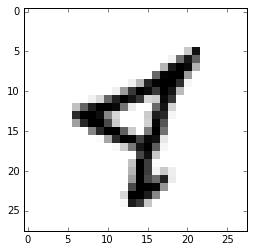

{
  "meta": {
    "puid": "gu2ub8a1uvrq2gpafprgl0ui1q", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    "ndarray": [
      [
        8.841673843562603e-05, 
        0.0002128362684743479, 
        1.527012386759452e-06, 
        0.0001617049565538764, 
        0.9654648303985596, 
        0.004503559321165085, 
        0.00023241718008648604, 
        0.021323835477232933, 
        0.0016595461638644338, 
        0.006351306103169918
      ]
    ]
  }
}


In [175]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

gRPC Request

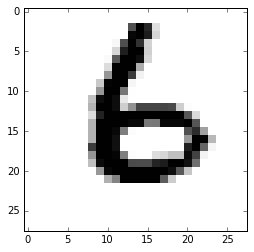

meta {
  puid: "1p1f9omvslevo90d2gu2lai6p7"
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  tensor {
    shape: 1
    shape: 10
    values: 9.23067000258e-06
    values: 4.25671160542e-08
    values: 0.000154912471771
    values: 4.92504454996e-07
    values: 4.00531462219e-06
    values: 0.000257794425124
    values: 0.999498009682
    values: 6.72839006732e-10
    values: 6.96157512721e-05
    values: 5.95818846705e-06
  }
}



In [178]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((784))
grpc_request("mnist-classifier",data)

# Next Steps

## AB Test
 Run an AB Test between Tensorflow model and SKLearn Random Forest.
 

In [179]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

In [172]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment "mnist-classifier" created


0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


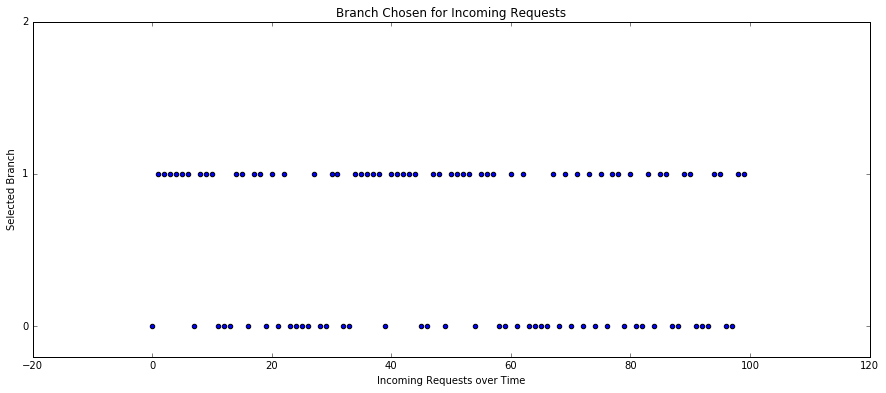

In [181]:
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("random-ab-test")
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")

## Multi-Armed Bandit
Run a e-greey multi-armed bandit to push traffic to best performing model.

In [182]:
!pygmentize ../k8s_serving/epsilon_greedy.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

In [183]:
!kubectl apply -f ../k8s_serving/epsilon_greedy.json

seldondeployment "mnist-classifier" configured


0/200
10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
[0.0, 159.0]


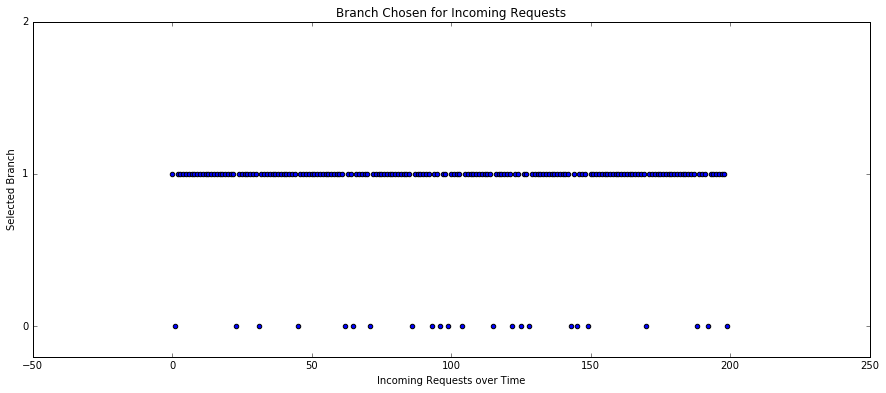

In [185]:
score = [0.0,0.0]
sz = 200
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("eg-router")
    proba = response["data"]["ndarray"][0]
    predicted = proba.index(max(proba))
    correct = np.argmax(batch_ys[idx])
    if predicted == correct:
        score[route] = score[route] + 1
        send_feedback_rest("mnist-classifier",request,response,reward=1)
    else:
        send_feedback_rest("mnist-classifier",request,response,reward=0)
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")
print score